In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob


In [2]:
def check_overlap(interval, array):
    height = array.shape[0]
    intervals = np.stack([np.tile(interval,(height,1)), array],axis=0)
    anchor =  (intervals[0,:,0] < intervals[1,:,0]).astype(int)
    return intervals[1-anchor,np.arange(height),1] > intervals[anchor,np.arange(height),0]


In [3]:
F1R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
F1R2_fn = '../data/FASTQ/FADS1_rep9detailed.txt'

F2R1_fn = '../data/FASTQ/FADS2_rep8detailed.txt'
F2R2_fn = '../data/FASTQ/FADS2_rep11detailed.txt'

F3R1_fn = '../data/FASTQ/FADS3_rep7detailed.txt'
F3R2_fn = '../data/FASTQ/FADS3_rep8detailed.txt'

FnR1_fn = '../data/FASTQ/FEN1_rep11detailed.txt'
FnR2_fn = '../data/FASTQ/FEN1_rep12detailed.txt'

fn_list = [F1R1_fn,F1R2_fn,F2R1_fn,F2R2_fn,
           F3R1_fn,F3R2_fn,FnR1_fn,FnR2_fn]

exp_ids = ['F1R1','F1R2','F2R1','F2R2',
           'F3R1','F3R2','FnR1','FnR2']

fullinfo= [("FADS1",1), ("FADS1",2), ("FADS2",1), ("FADS2",2), 
           ("FADS3",1), ("FADS3",2), ("FEN1",1), ("FEN1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [4]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [6]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [7]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('../data/*__sigpeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


8
10


In [8]:
test_peaks.loc[ test_peaks['exp_id'] == 'F1R1', 'assay' ].unique().item()

'FADS1'

In [9]:
data

,F1R1,F1R2,F2R1,F2R2,F3R1,F3R2,FnR1,FnR2,cutsite
Coordinates,,,,,,,,,
chr11:61788524-61788546:-,-0.446006,-0.717688,-0.446532,-0.424917,-0.208681,-0.215305,0.093006,0.597376,61788527
chr11:61788527-61788549:-,-0.585573,-0.444525,0.150981,-0.064382,-0.342047,-0.060320,-0.541011,0.875115,61788530
chr11:61788560-61788582:+,-0.414482,-0.325180,-0.752557,-0.219445,-0.108891,-0.073516,-0.350920,0.512321,61788578
chr11:61788568-61788590:+,-0.803122,-0.093714,-0.186454,0.296454,-0.303729,-0.411980,0.498659,0.100331,61788586
chr11:61788568-61788590:-,-0.682111,-1.208815,-0.347912,-0.037850,-0.265037,-0.103503,1.012557,0.526470,61788571
chr11:61788583-61788605:-,-1.077559,-0.293761,-0.324383,0.030937,0.318053,0.171850,-0.013606,0.608911,61788586
chr11:61788622-61788644:+,0.054382,-0.559616,-0.361578,0.023826,-0.302328,-0.013202,0.422857,0.572311,61788640
chr11:61788630-61788652:+,-0.498486,-0.488097,0.158075,-0.125401,0.040588,0.324861,5.288267,-4.110874,61788648
chr11:61788645-61788667:-,-0.792547,-1.033473,-0.401473,-0.349295,-0.040351,-0.619039,2.616834,1.248847,61788648


In [10]:
test_peaks

,chr,start,end,exp_id,assay,replicate
0,chr11,61813200,61813600,F1R1,FADS1,1
1,chr11,61814000,61818400,F1R1,FADS1,1
2,chr11,61833300,61835900,F1R1,FADS1,1
3,chr11,61837300,61837500,F1R1,FADS1,1
4,chr11,61840400,61840500,F1R1,FADS1,1
5,chr11,61840900,61841000,F1R1,FADS1,1
6,chr11,61841200,61841400,F1R1,FADS1,1
7,chr11,61841500,61842900,F1R1,FADS1,1
8,chr11,61869000,61871800,F1R1,FADS1,1
9,chr11,61800900,61801000,F1R2,FADS1,2


In [11]:
def plot_hff_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    # Subset cutsite scores
    sub_cuts = cutsite_data.loc[:,plot_ids].dropna(axis=1)
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([data['cutsite'].values, 
                                                       (data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    hold_col = plt.rcParams['axes.prop_cycle'].by_key()['color']*2
    col_dict = { exp_id: color
                 for exp_id, color 
                 in zip(plot_ids, 
                        hold_col[:len(plot_ids)]
                       )
               }
    score_max = sub_cuts.loc[:, plot_ids].dropna(axis=1).max().max()
    score_min = sub_cuts.loc[:, plot_ids].dropna(axis=1).min().min()
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    for i, exp_id in enumerate(col_dict.keys()):
        sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
        peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
        for j, row in sub_sub_peaks.iterrows():
            ax.hlines(y=peak_position, 
                      xmin=row['start'], xmax=row['end'],
                      color=col_dict[exp_id])
        if exp_id in cut_types:
            ax.scatter(sub_cuts['cutsite'],sub_cuts[exp_id],color=col_dict[exp_id],s=8,alpha=0.5)
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=col_dict[color]) for color in plot_ids ]
    ax.legend(custom_lines, plot_ids,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    return fig
            

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


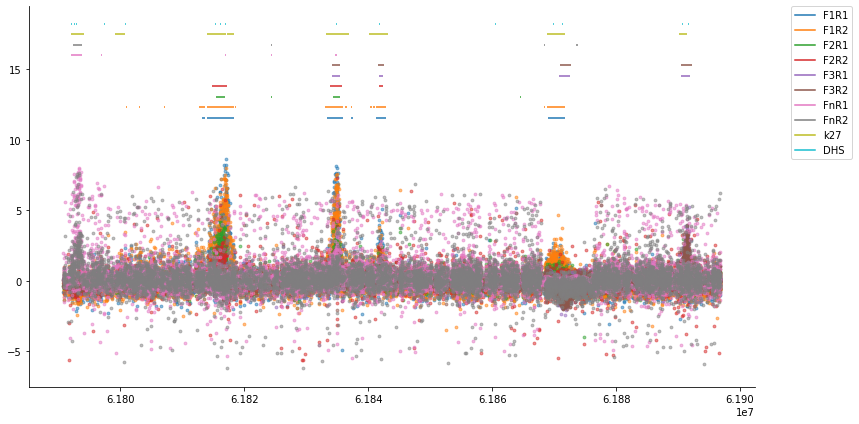

In [12]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


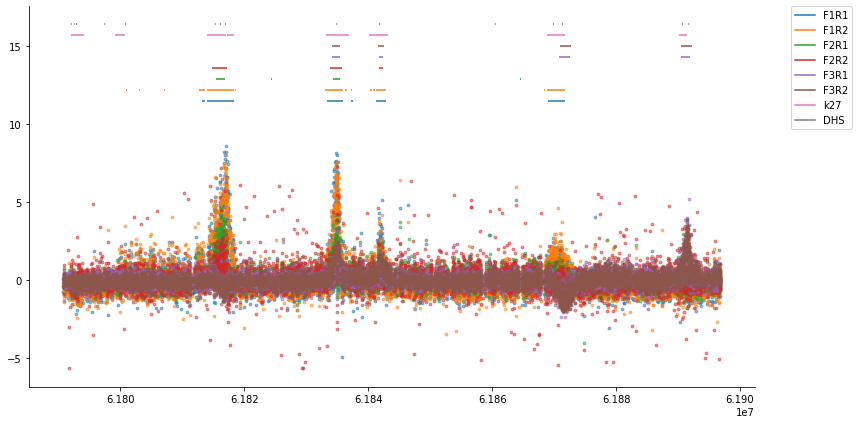

In [13]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


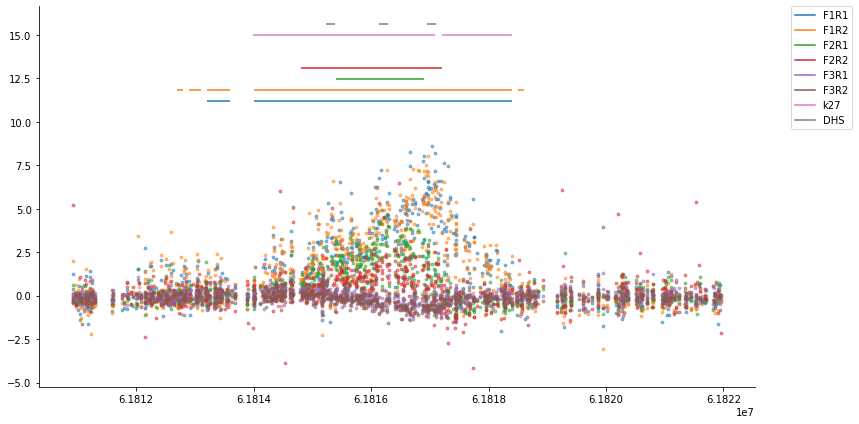

In [14]:
fig_h = plot_hff_cutsites(np.array([[61810908,61822034]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


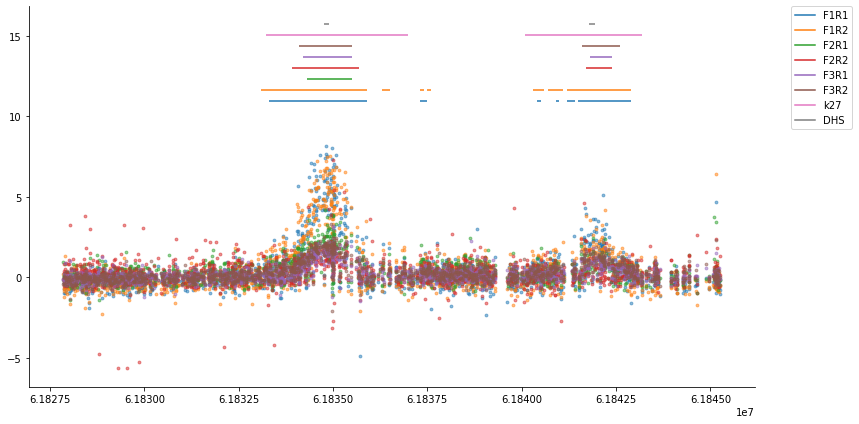

In [15]:
fig_h = plot_hff_cutsites(np.array([[61827852,61845270]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


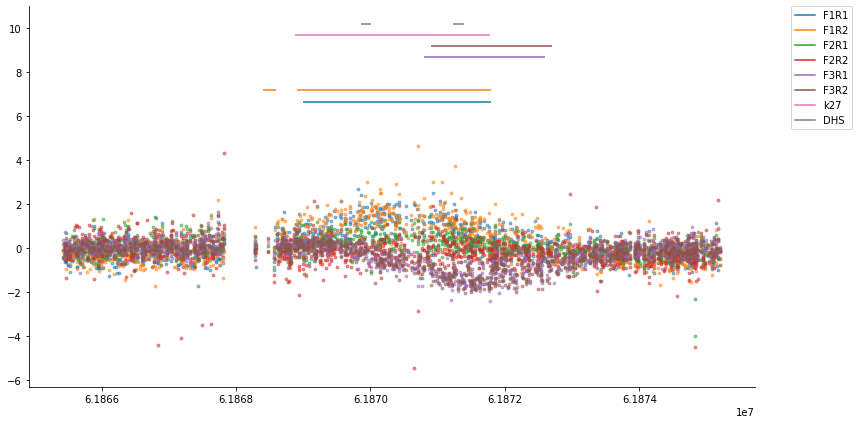

In [16]:
fig_h = plot_hff_cutsites(np.array([[61865430,61875290]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])


In [17]:
def plot_combined_cutsites(plot_interval, cutsite_data, peak_data, plot_ids):
    # Subset cutsite scores
    sub_cuts = cutsite_data.loc[:,plot_ids].dropna(axis=1)
    sub_cuts['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                            if coord.split(':')[-1] == '+' 
                            else 
                            int(coord.split(':')[1].split('-')[0]) + 3 
                            for coord in sub_cuts.index ]
    slice_cuts = check_overlap(plot_interval,np.vstack([data['cutsite'].values, 
                                                       (data['cutsite']+1).values]).T)
    sub_cuts = sub_cuts.loc[slice_cuts, :]
    # Subset peak intervals
    sub_peaks= check_overlap(plot_interval, peak_data.loc[:,('start','end')].values)
    sub_peaks= peak_data.loc[sub_peaks,:]
    sub_peaks= sub_peaks.loc[ sub_peaks['exp_id'].isin(plot_ids) ]
    
    cut_types  = np.unique(sub_cuts.columns)
    peak_types = np.unique(sub_peaks['exp_id'])
    
    score_max = sub_cuts.loc[:, plot_ids].dropna(axis=1).max().max()
    score_min = sub_cuts.loc[:, plot_ids].dropna(axis=1).min().min()
    score_gap = score_max - \
                score_min
    fig = plt.figure(figsize=(12,6))
    ax  = plt.subplot(111)
    avail_data = test_peaks.loc[test_peaks['exp_id'].isin(plot_ids),('exp_id','assay','replicate')].drop_duplicates()
    exp2assay = {}
    assay2exp = {}
    for row in avail_data.iterrows():
        exp2assay[row[1]['exp_id']] = row[1]['assay']
        try:
            assay2exp[row[1]['assay']].append(row[1]['exp_id'])
        except:
            assay2exp[row[1]['assay']] = [row[1]['exp_id']]
    for i, assay in enumerate(avail_data['assay'].unique()):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        for exp_id in assay2exp[assay]:
            sub_sub_peaks = sub_peaks.loc[ sub_peaks['exp_id'] == exp_id, : ]
            peak_position = score_max + ( ( 0.2+(i*0.05) ) * score_gap )
            for j, row in sub_sub_peaks.iterrows():
                ax.hlines(y=peak_position, 
                          xmin=row['start'], xmax=row['end'],
                          color=color)
        have_cuts = [exp_id for exp_id in assay2exp[assay] if exp_id in sub_cuts.columns]
        if len(have_cuts) > 0:
            print(assay)
            ax.scatter(sub_cuts['cutsite'],sub_cuts.loc[:,have_cuts].mean(axis=1),color=color,s=4,alpha=0.5)
            ax.vlines(x=sub_cuts['cutsite'],
                      ymin=sub_cuts.loc[:,have_cuts].min(axis=1),
                      ymax=sub_cuts.loc[:,have_cuts].max(axis=1),
                      color=color,linewidth=0.5)
            print(sum((sub_cuts.loc[:,have_cuts].max(axis=1) - sub_cuts.loc[:,have_cuts].min(axis=1)) < 0.001))
            
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    custom_lines = [ Line2D([0], [0], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i]) for i, assay in enumerate(avail_data['assay'].unique()) ]
    ax.legend(custom_lines, avail_data['assay'].unique(),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    return fig
            

FADS1
1
FADS2
1
FADS3
7
FEN1
2


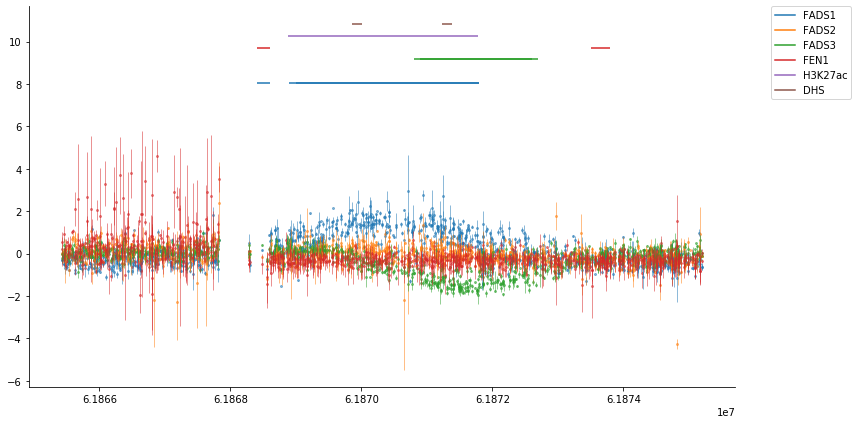

In [18]:
fig_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__all.pdf')

FADS1
1
FADS2
1
FADS3
7


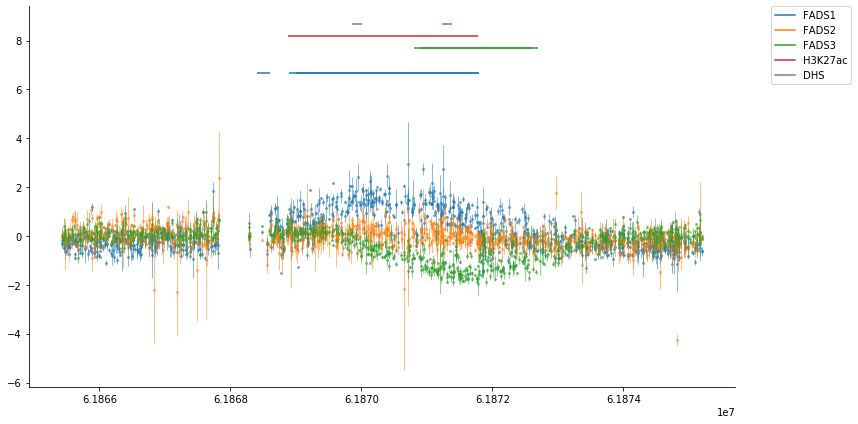

In [19]:
fig_h = plot_combined_cutsites(np.array([[61865430,61875290]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61865430_61875290__noFEN1.pdf')

FADS1
17
FADS2
11
FADS3
28
FEN1
45


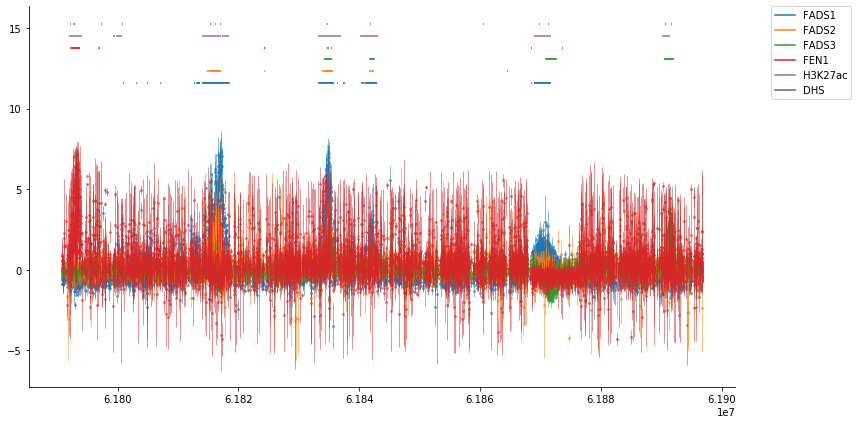

In [20]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','FnR1','FnR2','k27','DHS'])


FADS1
17


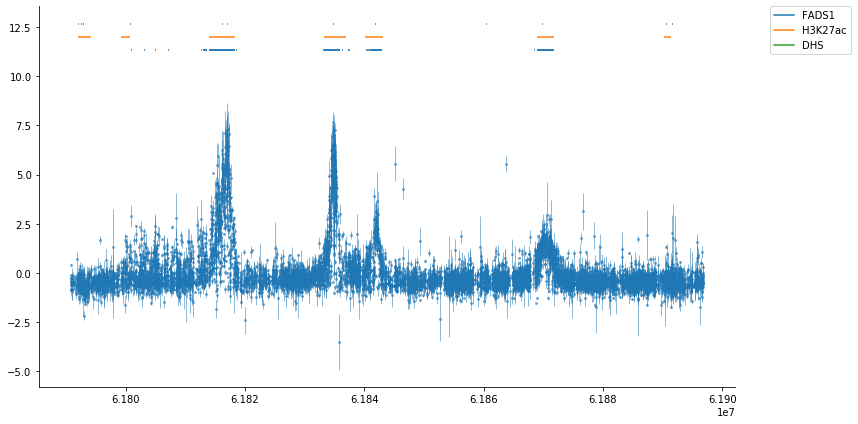

In [21]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F1R1','F1R2','k27','DHS'])


FADS2
11


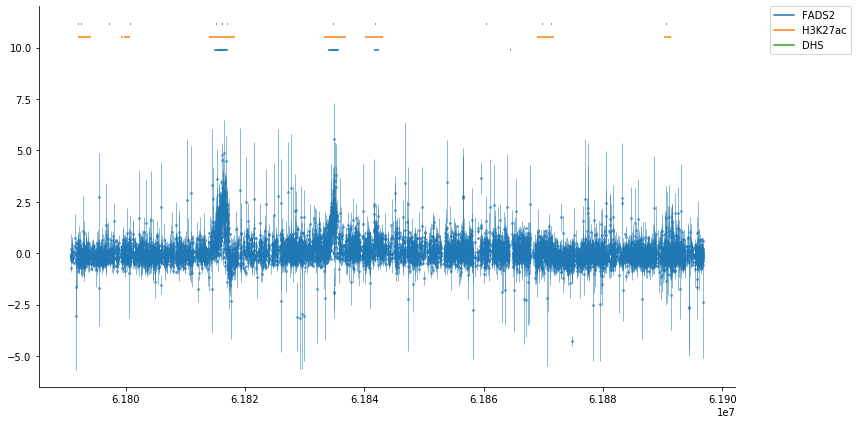

In [22]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F2R1','F2R2','k27','DHS'])


FADS3
28


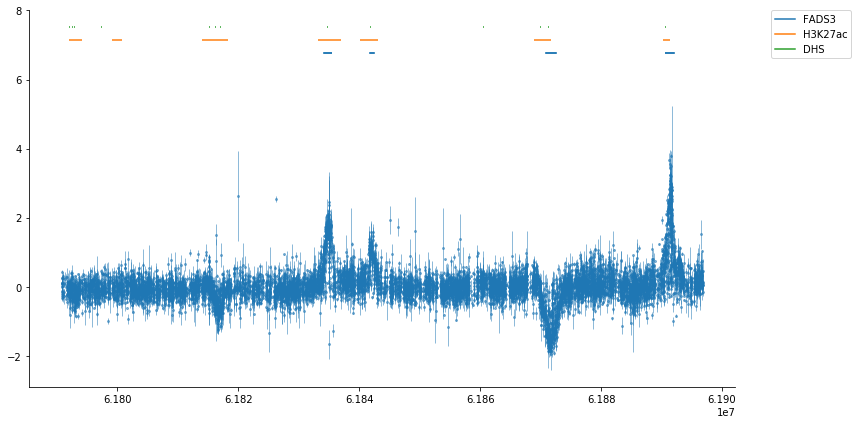

In [23]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['F3R1','F3R2','k27','DHS'])


FEN1
45


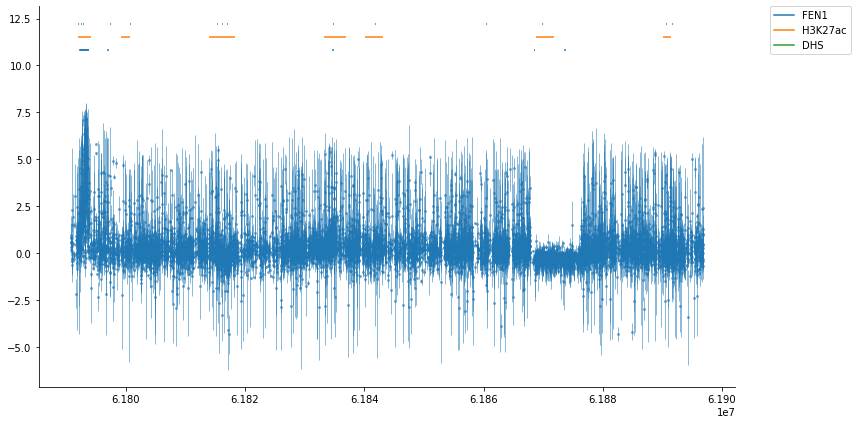

In [24]:
fig_h = plot_combined_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['FnR1','FnR2','k27','DHS'])


FADS1
1
FADS2
1
FADS3
1


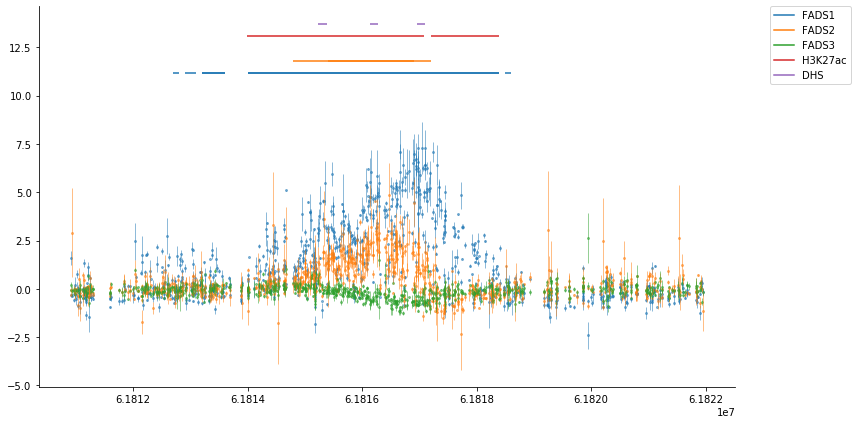

In [25]:
fig_h = plot_combined_cutsites(np.array([[61810908,61822034]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61810908_61822034__noFEN1.pdf')

FADS1
4
FADS2
5
FADS3
7


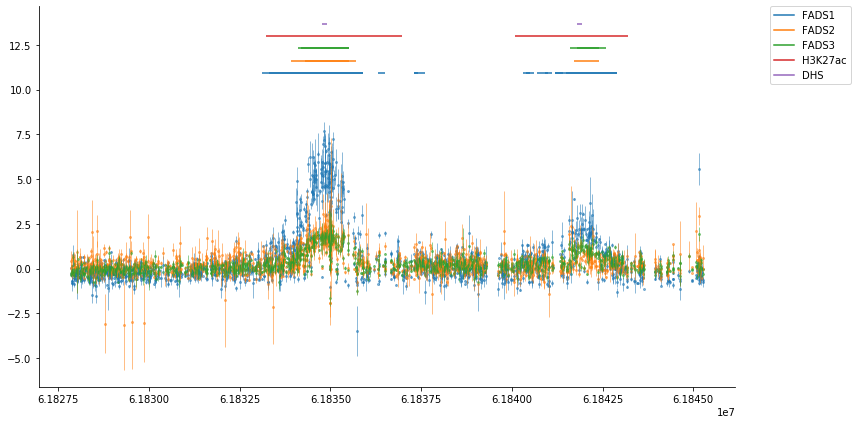

In [26]:
fig_h = plot_combined_cutsites(np.array([[61827852,61845270]]), 
          data, test_peaks, plot_ids=['F1R1','F1R2','F2R1','F2R2','F3R1','F3R2','k27','DHS'])
fig_h.savefig('FADS_locus__61827852_61845270__noFEN1.pdf')

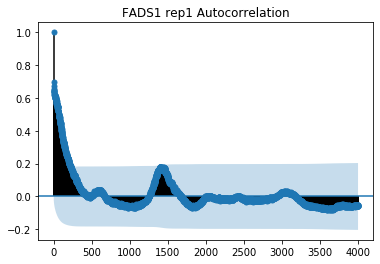

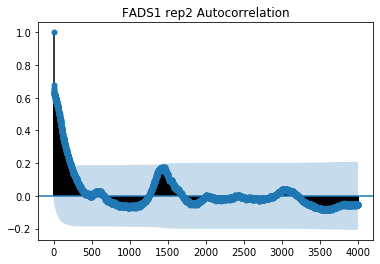

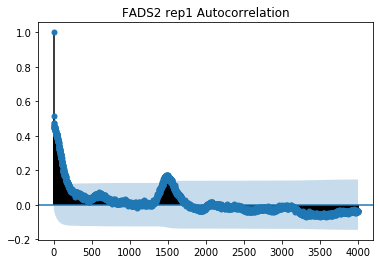

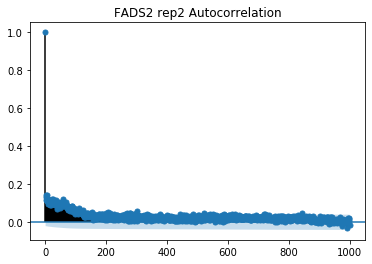

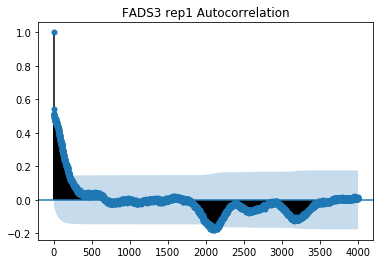

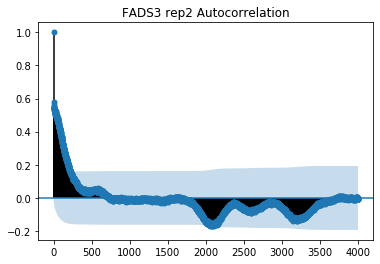

In [27]:
plot_acf( data['F1R1'], lags=4000, title='FADS1 rep1 Autocorrelation' )
plt.savefig('FADS1_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F1R2'], lags=4000, title='FADS1 rep2 Autocorrelation' );
plt.savefig('FADS1_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R1'], lags=4000, title='FADS2 rep1 Autocorrelation' );
plt.savefig('FADS2_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F2R2'], lags=1000, title='FADS2 rep2 Autocorrelation' );
plt.savefig('FADS2_rep2__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R1'], lags=4000, title='FADS3 rep1 Autocorrelation' );
plt.savefig('FADS3_rep1__autocorrelation.pdf')
plt.show()
plot_acf( data['F3R2'], lags=4000, title='FADS3 rep2 Autocorrelation' );
plt.savefig('FADS3_rep2__autocorrelation.pdf')
plt.show()


In [28]:
pos_strand = [ True if ':+' in x else False for x in data.index ]
neg_strand = [ True if ':-' in x else False for x in data.index ]

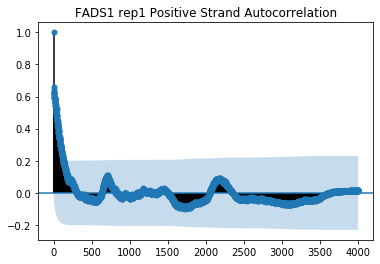

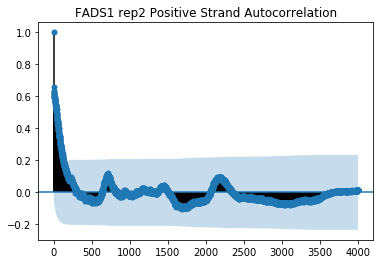

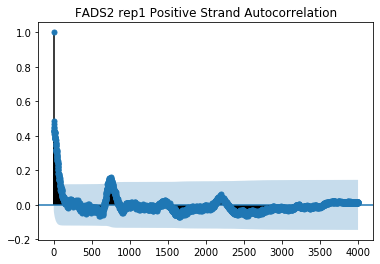

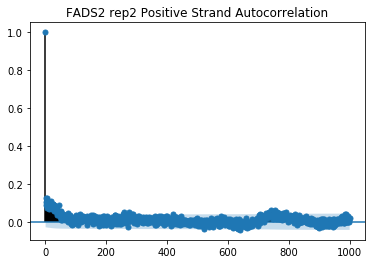

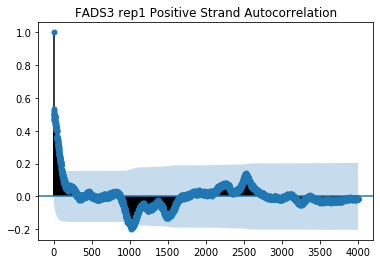

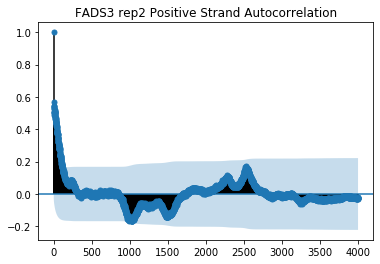

In [29]:
plot_acf( data.loc[pos_strand,'F1R1'], lags=4000, title='FADS1 rep1 Positive Strand Autocorrelation' )
plt.savefig('FADS1_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F1R2'], lags=4000, title='FADS1 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS1_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R1'], lags=4000, title='FADS2 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F2R2'], lags=1000, title='FADS2 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS2_rep2_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R1'], lags=4000, title='FADS3 rep1 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep1_pos__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[pos_strand,'F3R2'], lags=4000, title='FADS3 rep2 Positive Strand Autocorrelation' );
plt.savefig('FADS3_rep2_pos__autocorrelation.pdf')
plt.show()


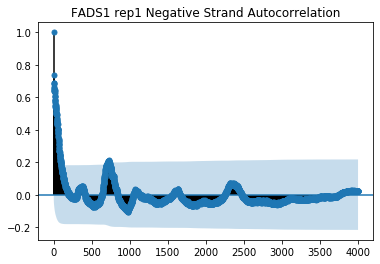

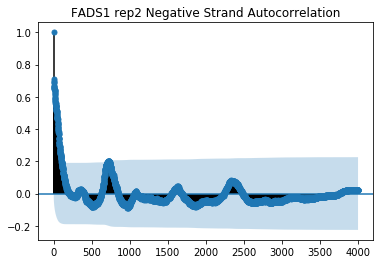

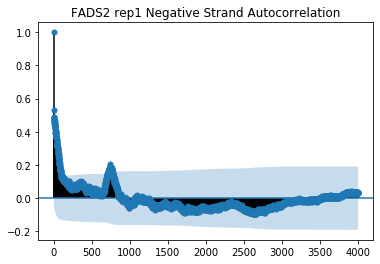

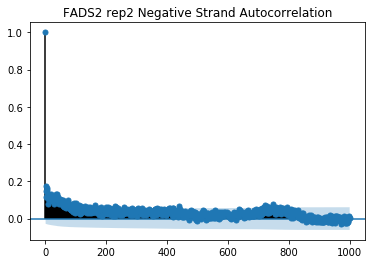

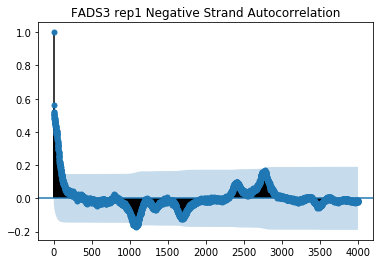

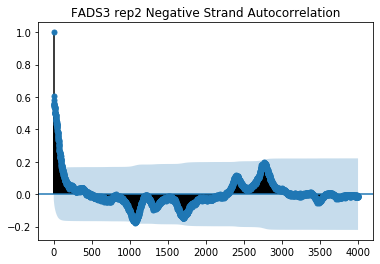

In [30]:
plot_acf( data.loc[neg_strand,'F1R1'], lags=4000, title='FADS1 rep1 Negative Strand Autocorrelation' )
plt.savefig('FADS1_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F1R2'], lags=4000, title='FADS1 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS1_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R1'], lags=4000, title='FADS2 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F2R2'], lags=1000, title='FADS2 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS2_rep2_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R1'], lags=4000, title='FADS3 rep1 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep1_neg__autocorrelation.pdf')
plt.show()
plot_acf( data.loc[neg_strand,'F3R2'], lags=4000, title='FADS3 rep2 Negative Strand Autocorrelation' );
plt.savefig('FADS3_rep2_neg__autocorrelation.pdf')
plt.show()


# Subsetting analysis

In [31]:
S0R1_fn = '../data/FASTQ/FADS1_rep8detailed.txt'
S1R1_fn = 'subset_10__FADS1_rep8detailed.txt'
S2R1_fn = 'subset_20__FADS1_rep8detailed.txt'
S3R1_fn = 'subset_30__FADS1_rep8detailed.txt'
S4R1_fn = 'subset_40__FADS1_rep8detailed.txt'
S5R1_fn = 'subset_50__FADS1_rep8detailed.txt'
S6R1_fn = 'subset_60__FADS1_rep8detailed.txt'
S7R1_fn = 'subset_70__FADS1_rep8detailed.txt'
S8R1_fn = 'subset_80__FADS1_rep8detailed.txt'
S9R1_fn = 'subset_90__FADS1_rep8detailed.txt'

fn_list = [S0R1_fn,S1R1_fn,S2R1_fn,S3R1_fn,S4R1_fn,
           S5R1_fn,S6R1_fn,S7R1_fn,S8R1_fn,S9R1_fn]

exp_ids = ['S0R1','S1R1','S2R1','S3R1','S4R1',
           'S5R1','S6R1','S7R1','S8R1','S9R1']

fullinfo= [("Sub00",1), ("Sub10",1), ("Sub20",1), ("Sub30",1), ("Sub40",1), 
           ("Sub50",1), ("Sub60",1), ("Sub70",1), ("Sub80",1), ("Sub90",1)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)

In [32]:
data = []
for i, fn in enumerate(fn_list):
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [34]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [35]:
sorted(glob.glob('191125_subset/*__mergedPeaks.bed'))

['191125_subset/subset_00__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_10__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_20__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_30__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_40__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_50__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_60__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_70__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_80__FADS1_rep8detailed__mergedPeaks.bed',
 '191125_subset/subset_90__FADS1_rep8detailed__mergedPeaks.bed']

In [36]:
test_peaks = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end']) for fn in sorted(glob.glob('191125_subset/*__mergedPeaks.bed')) ]
print(len(test_peaks))
extra_feat = [ pd.read_table(fn,sep='\t',header=None,names=['chr','start','end'],usecols=[0,1,2]) for fn in ['../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed','../data/DNASE_peaks_replicated.bed'] ]
[ test_peaks.append( feat.loc[ feat['chr'] == 'chr11' ,:] ) for feat in extra_feat ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print(len(test_peaks))
for exp_id, peaks_idx in zip(['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27','DHS'],range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/home/sagergosai/miniconda3/envs/hff/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


10
12


In [37]:
data

,S0R1,S1R1,S2R1,S3R1,S4R1,S5R1,S6R1,S7R1,S8R1,S9R1,cutsite
chr11:61788524-61788546:-,-0.444506,-0.443003,-0.438482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61788527
chr11:61788527-61788549:-,-0.585573,-0.584187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61788530
chr11:61788560-61788582:+,-0.413584,-0.411786,-0.408179,-0.400926,-0.404559,-0.396366,-0.385336,-0.373249,-0.338024,NaN,61788578
chr11:61788568-61788590:+,-0.803122,-0.802002,-0.797507,-0.790728,-0.794123,-0.785042,-0.774727,-0.763140,NaN,NaN,61788586
chr11:61788568-61788590:-,-0.682111,-0.678405,-0.675927,-0.668455,-0.670951,-0.663442,-0.653341,-0.640569,-0.606579,-0.543458,61788571
chr11:61788583-61788605:-,-1.077559,-1.072226,-1.069548,-1.061473,-1.064172,NaN,NaN,NaN,NaN,NaN,61788586
chr11:61788622-61788644:+,0.054382,0.056380,0.058382,0.066431,0.064413,0.070479,NaN,NaN,NaN,NaN,61788640
chr11:61788630-61788652:+,-0.498486,-0.498486,-0.492739,-0.484055,-0.489853,-0.478224,-0.469414,NaN,NaN,NaN,61788648
chr11:61788645-61788667:-,-0.792547,-0.790690,-0.788830,-0.779475,-0.783228,-0.775709,NaN,NaN,NaN,NaN,61788648
chr11:61788663-61788685:-,-0.390866,-0.390866,-0.387921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61788666


In [38]:
test_peaks

,chr,start,end,exp_id,assay,replicate
0,chr11,61813200,61813600,S0R1,Sub00,1
1,chr11,61814000,61818400,S0R1,Sub00,1
2,chr11,61833300,61835900,S0R1,Sub00,1
3,chr11,61837300,61837500,S0R1,Sub00,1
4,chr11,61840400,61840500,S0R1,Sub00,1
5,chr11,61840900,61841000,S0R1,Sub00,1
6,chr11,61841200,61841400,S0R1,Sub00,1
7,chr11,61841500,61842900,S0R1,Sub00,1
8,chr11,61869000,61871800,S0R1,Sub00,1
9,chr11,61813200,61813700,S1R1,Sub10,1


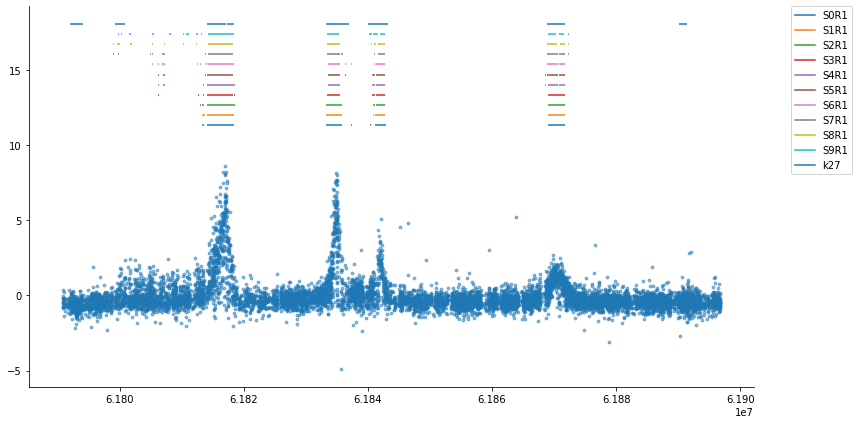

In [39]:
fig_h = plot_hff_cutsites(np.array([[61790805,61896817]]), 
                  data, test_peaks, plot_ids=['S0R1','S1R1','S2R1','S3R1','S4R1','S5R1','S6R1','S7R1','S8R1','S9R1','k27'])
fig_h.savefig('FADS_locus__subsettingFADS1.pdf')

In [40]:
def intersect_bed3(array1, array2):
    output = []
    uniq_chr = [ x for x in np.unique(array1[:,0]) if x in np.unique(array2[:,0]) ]
    for on_chr in uniq_chr:
        if sum(array1[:,0] == on_chr) >= sum(array2[:,0] == on_chr):
            longer = array1[ array1[:,0] == on_chr ]
            shorter= array2[ array2[:,0] == on_chr ]
        else:
            longer = array2[ array2[:,0] == on_chr ]
            shorter= array1[ array1[:,0] == on_chr ]
            
        longer =  longer[  longer[:,1].argsort() ]
        shorter= shorter[ shorter[:,1].argsort() ]
        for i in range(shorter.shape[0]):
            left_check = shorter[i,1] < longer[:,2]
            right_check= shorter[i,2] >=longer[:,1]
            overlap = longer[ left_check & right_check ]
            for j in range(overlap.shape[0]):
                left = max(shorter[i,1],overlap[j,1])
                right= min(shorter[i,2],overlap[j,2])
                output.append([shorter[i,0],left,right])
    return pd.DataFrame(output,columns=['chr','start','end'])

In [41]:
overlap_with_k27ac = []
for i in range(10):
    hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
    hold_sub = test_peaks.loc[test_peaks['assay']=='Sub{}0'.format(i),('chr','start','end')].values
    total_sub_nt = sum(hold_sub[:,2] - hold_sub[:,1])
    inter_sub_nt = sum(intersect_bed3(hold_sub, hold_k27).loc[:,'end'] - intersect_bed3(hold_sub, hold_k27).loc[:,'start'])
    print("{}/{}={}".format(inter_sub_nt,total_sub_nt,inter_sub_nt/total_sub_nt))
    overlap_with_k27ac.append([inter_sub_nt,total_sub_nt])
    

11458/12200=0.9391803278688524
11458/12200=0.9391803278688524
11358/12400=0.9159677419354839
11030/11700=0.9427350427350427
10650/11400=0.9342105263157895
10882/11600=0.9381034482758621
10850/12200=0.889344262295082
10782/12000=0.8985
10545/11800=0.8936440677966102
10499/12900=0.813875968992248


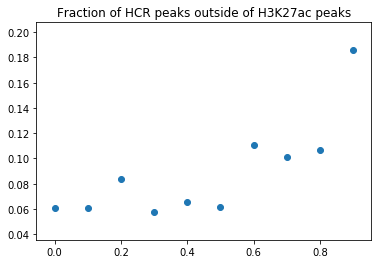

In [42]:
plt.scatter( np.arange(10)/10, [ (y-x)/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks outside of H3K27ac peaks")

plt.savefig("HCR_Histone_peak_inclusion_w_subsetting.pdf")

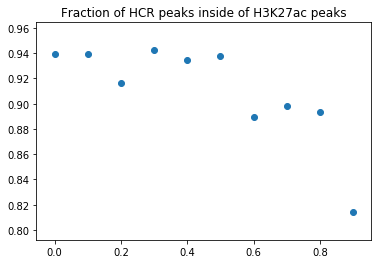

In [43]:
plt.scatter( np.arange(10)/10, [ x/y for x,y in overlap_with_k27ac ] )

plt.title("Fraction of HCR peaks inside of H3K27ac peaks")
plt.savefig("HCR_Histone_peak_exclusion_w_subsetting.pdf")

In [73]:
hold_k27 = test_peaks.loc[test_peaks['assay']=='H3K27ac',('chr','start','end')].values
hold_s10 = test_peaks.loc[test_peaks['assay']=='Sub10',('chr','start','end')].values

In [83]:
hold_k27[ (hold_k27[:,2] > 61815235) & (hold_k27[:,1] < 61871385) ]

array([['chr11', 61815235, 61815385],
       ['chr11', 61816135, 61816285],
       ['chr11', 61816955, 61817105],
       ['chr11', 61834755, 61834905],
       ['chr11', 61841795, 61841945],
       ['chr11', 61860455, 61860605],
       ['chr11', 61869855, 61870005],
       ['chr11', 61871235, 61871385]], dtype=object)

In [84]:
hold_s10

array([['chr11', 61812900, 61813100],
       ['chr11', 61813200, 61813600],
       ['chr11', 61814100, 61818600],
       ['chr11', 61833300, 61835900],
       ['chr11', 61840800, 61841100],
       ['chr11', 61841300, 61842800],
       ['chr11', 61868500, 61868600],
       ['chr11', 61869000, 61871800]], dtype=object)

In [89]:
sum(intersect_bed3(hold_s10, hold_k27).loc[:,'end'] - intersect_bed3(hold_s10, hold_k27).loc[:,'start'])

1050

In [90]:
sum(hold_s10[:,2] - hold_s10[:,1])

12400

In [69]:
list(hold[ hold[:,1].argsort() ][:,1])

[14, 30, 35]

In [63]:
hold = np.array([[1,30],[2,14],[3,35]])
hold[ hold[:,1].argsort() ]

array([[ 2, 14],
       [ 1, 30],
       [ 3, 35]])

In [51]:
plt.rcParams['axes.prop_cycle'].by_key()['color']

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']